In [1]:
import sys
sys.path.append('..')

from src import Environment, Agent
from src.agents import FSVI_Agent
from src.simulation import run_test, SimulationHistory
from src.test_setups import run_all_starts_test

from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import cupy as cp

In [2]:
from cupy.cuda import runtime as cuda_runtime
cuda_runtime.setDevice(0)

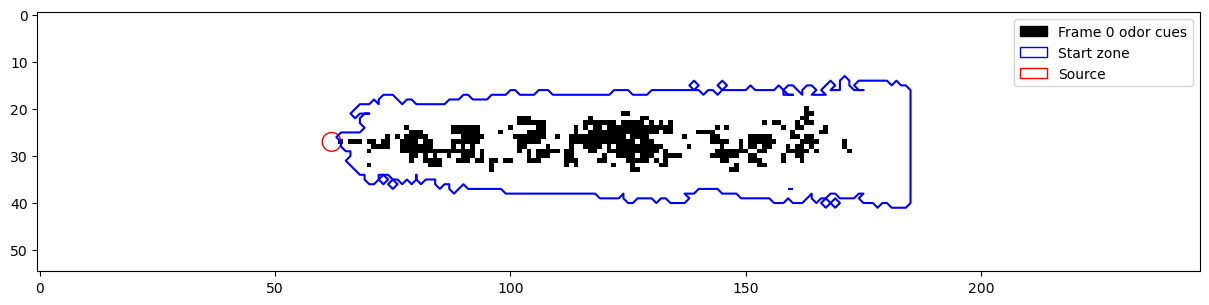

In [3]:
data_path = "/storage/rando/data/nose_data_27_123.npy" # INSERT YOUR PATH

env = Environment(data=data_path,
                  source_position=[13, 0],
                  source_radius=2,
                  margins=[14, 62],
                  boundary_condition='wrap_vertical',
                  start_zone='odor_present',
                  odor_present_treshold=3e-6)

env.plot()

In [4]:
env.save(force=True)

Environment saved to: ./Env-55_247-edge_wrap_vertical-start_odor_present-source_27_62_radius2


In [5]:
ag = FSVI_Agent(env)

[05/06/2024, 13:29:04] Instantiation of MDP Model:
[05/06/2024, 13:29:04] - 13585 states
[05/06/2024, 13:29:04] - 4 actions
[05/06/2024, 13:29:04] - At most 1 reachable states per state-action pair
[05/06/2024, 13:29:04] - Starting generation of transitions table
[05/06/2024, 13:29:04]     > [Warning] No transition matrix or function provided but reachable states are, so probability to reach any reachable states will "1 / reachable state count" so here: 1.000.
[05/06/2024, 13:29:04]     > Done in 0.000s
[05/06/2024, 13:29:04] - Generation of state grid
[05/06/2024, 13:29:04] - Generating start probabilities table
[05/06/2024, 13:29:04] - Starting computation of reachable state probabilities from transition data
[05/06/2024, 13:29:04]     > Done in 0.000s

[05/06/2024, 13:29:04] POMDP particular parameters:
[05/06/2024, 13:29:04] - 3 observations
[05/06/2024, 13:29:04] - Starting of transitional observations for reachable states table
[05/06/2024, 13:29:04]     > Done in 0.002s
[05/06/2

In [6]:
hist = ag.train(expansions=300, force=True, use_gpu=True)

print(hist.summary)

[05/06/2024, 13:29:04] MDP_policy, not provided. Solving MDP with Value Iteration...
[05/06/2024, 13:29:04] Sending Model to GPU...
[05/06/2024, 13:29:04]     > Done in 0.178s


  0%|          | 0/1000 [00:00<?, ?it/s]

Summary of Value Iteration run
  - Model: 13585-state, 4-action
  - Converged in 918 iterations and 0.6303 seconds
  - Took on average 0.0007s per iteration


Expansions:   0%|          | 0/300 [00:00<?, ?it/s]

Summary of Value Iteration run
  - Model: 13585 state, 4 action, 3 observations
  - Converged or stopped after 300 expansion steps and 300 backup steps.
  - Resulting value function has 2267 alpha vectors.
  - Converged in 22.0837s

  - Expand function took on average 0.0077s and yielded on average 630.69 beliefs per iteration. (0.0001s/it/belief)
  - Backup function took on average 0.0659s and yielded on average 7.54 alpha vectors per iteration. (0.0004s/it/alpha)
  - Pruning function took on average 0.0000s and yielded on average prunings of 0.00 alpha vectors per iteration.


[Warning] 'as_grid' parameter set to False but state count is >3 so it will be plotted as a grid


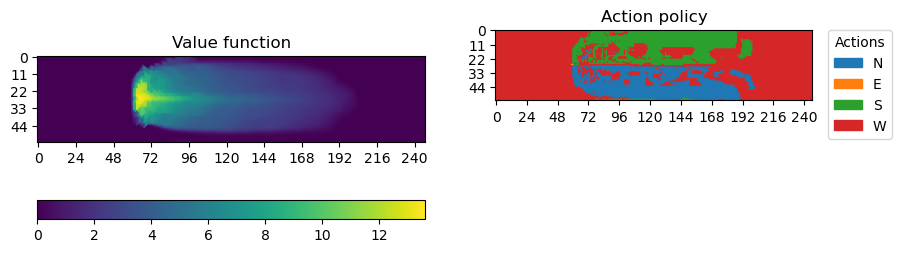

In [7]:
ag.value_function.plot()

In [8]:
ag.save(force=False, save_environment=False)

Agent saved to: ./Agent-FSVI_Agent-tresh_3e-06-trained_05062024_132930


In [11]:
hist = run_all_starts_test(ag, use_gpu=False)
# hist = run_test(n=100, agent=ag, time_shift=2400, use_gpu=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

Simulations done in 92.715s:
Simulations reached goal: 2379/2393 (14 failures) (99.41%)
	- Average step count: 98.23735896364396 (Successfull only: 92.93064312736443)
	- Extra steps: 27.20392812369411 (Successful only: 21.703236654056326)
	- Average discounted rewards (ADR): 0.442 (Successfull only: 0.445) (discount: 0.99)
	- Tmin/T: 0.798 (Successful only: 0.802)


In [ ]:
'''Simulations done in 4.308s:
Simulations reached goal: 2379/2393 (14 failures) (99.41%)
	- Average step count: 98.23735896364396 (Successfull only: 92.93064312736443)
	- Extra steps: 27.20392812369411 (Successful only: 21.703236654056326)
	- Average discounted rewards (ADR): 0.442 (Successfull only: 0.445) (discount: 0.99)
	- Tmin/T: 0.798 (Successful only: 0.802)'''

In [10]:
hist.save()

Simulations saved to: ./Simulations-s_55_247-n_2393-05062024_133013-horizon_1000.csv


In [12]:
n = len(hist.start_state)
done_sim_count = np.sum(hist.done_at_step >= 0)

# Metrics
sim_is_done = hist.done_at_step >= 0
done_at_step_with_max = np.where(hist.done_at_step < 0, len(hist.states), hist.done_at_step)
discounted_rewards = (hist.reward_discount) ** done_at_step_with_max

t_min = hist.environment.distance_to_source(hist.start_state)
extra_steps = done_at_step_with_max - t_min
t_min_over_t = t_min / done_at_step_with_max

In [16]:
np.std(extra_steps[sim_is_done])

25.770305640950006

In [13]:
hist2 = SimulationHistory.load_from_file('./Simulations-s_55_247-n_100-horizon_198-03192024_181337.csv')

Environment "55_247-edge_wrap_vertical-start_odor_present-source_27_62_radius2" loaded from memory


Agent used is not tracked


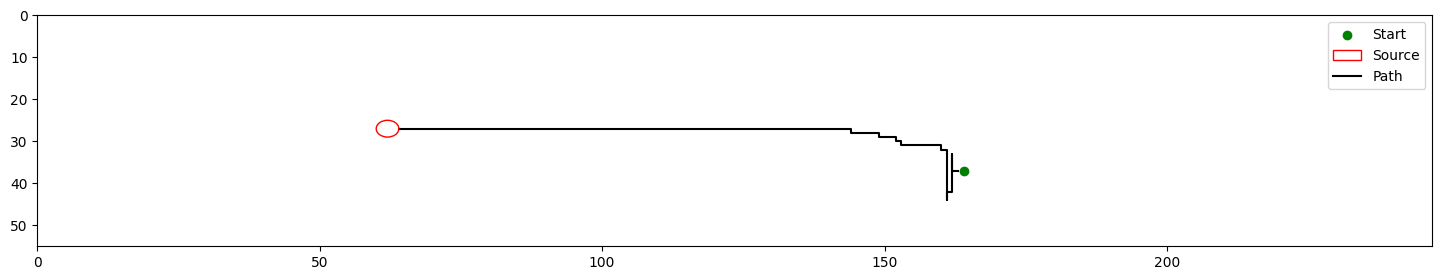

In [16]:
hist2.plot(10)